George Bennett


In this project I will be answering four questions about the Northwind database using statistical tests: <br>
* Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
* Do different shippers have different freight costs?
* Is there a statistically significant difference in demand of produce each month?
* Do products in the Meat/Poultry category have a higher unit price than products in the Seafood category?

To begin this project I will import necessary libraries and take a look at the database's table names and the database ERD

Import Libraries

In [40]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

Here I will create a connection to the database

In [41]:
conn = sqlite3.connect("Northwind_small.sqlite")
c = conn.cursor()

Then I will find the table names

In [42]:
query = """
SELECT name FROM sqlite_master WHERE type = "table"
"""
c.execute(query).fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

View ERD

<img src="Northwind_ERD_updated.png">

Here I will place a helper function to help me calculate cohen's d later on. I found this function in the curriculum, but also at https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb


In [77]:
# This cell of code taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
def cohens_d(a, b):
    difference_of_means = abs(np.mean(a) - np.mean(b))
    na, nb = len(a), len(b)
    vara, varb = np.var(a), np.var(b)
    pooled_variance = (na * vara + nb * varb)/(na+nb)
    d = difference_of_means / np.sqrt(pooled_variance)
    return d

# Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

Some of the code for this question was copied from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb and some was copied from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb

To answer this question I will need to first obtain the data. I will query from the OrderDetail table. The Columns I need from OrderDetail are Quantity and Discount. Finally I will put the data into a pandas DataFrame.

In [44]:
# This cell of code taken from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb 
query = """
SELECT Quantity, Discount FROM OrderDetail
"""
df = pd.DataFrame(c.execute(query).fetchall())
df.columns = [x[0] for x in c.description]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB
None


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


Now that we have the data, I need to seperate the orders on discounted items from the orders on non-discounted items. I will do this with pandas' slicing method, creating two pandas series with the data.

In [45]:
# This cell of code taken from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb
discount_orders = df[df['Discount'] > 0].Quantity
non_discount_orders = df[df['Discount'] == 0].Quantity

Now that we have discounted orders and non-discounted orders we can see which has a higher quantity mean.

In [46]:
print("Discount orders quantity mean:" , round(discount_orders.mean(), 2))
print("Non-discounted orders quantity mean:", round(non_discount_orders.mean(), 2))

Discount orders quantity mean: 27.11
Non-discounted orders quantity mean: 21.72


Let's look at a visualization of the two series.

C:\Users\zasz\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


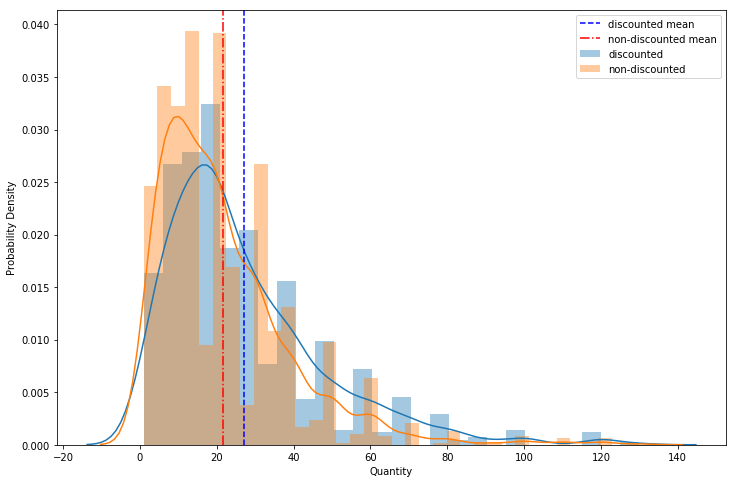

In [47]:
# This cell of code was taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
plt.figure(figsize=(12, 8))
sns.distplot(discount_orders, label='discounted')
sns.distplot(non_discount_orders, label='non-discounted')
plt.axvline(discount_orders.mean(), c='blue', linestyle = '--', label = 'discounted mean')
plt.axvline(non_discount_orders.mean(), c='red', linestyle = '-.', label = 'non-discounted mean')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Here we can see that Discounted orders tend to have more quantity.

To prove this we can use a statistical test. The alpha will be 0.05. The hypotheses will be as follows:

##### Null hypothesis: The means of discounted and non-discounted order quantities are equal <br>
##### Alternative hypothesis: The mean of discounted order quantities is greater than the mean of non-discounted order quantities

First I need to deturmine whether to use a student's T-test or a Welch's T-test. In order to know I need to check the variances of my two samples with a levene test. If the p-value from the test is over 0.05 then we can say that the variances are not statistically different from each other

In [48]:
stats.levene(discount_orders, non_discount_orders)

LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)

The variances have a statisticaly significant difference.

Also I need to know the length of both samples

In [49]:
print(len(discount_orders), len(non_discount_orders))

838 1317


Since the variances are different I will use a Welch's T-test

Assumptions for the Welch's T-test are as follows: <br>
* Normally distributed data or data of large sample size
* Randomly selected independent samples
* Unequal variances in the data

In [50]:
# this cell of code taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
t_stat, p_value = stats.ttest_ind(discount_orders, non_discount_orders, equal_var=False)

In [51]:
print(p_value)

5.65641429030433e-10


the p-value is below 0.05 so the null hypothesis can be rejected.

To futher prove this I will calculate effect size (cohen's d)

In [76]:
# this cell of code taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
cohens_d(discount_orders, non_discount_orders)

0.28641058366376676

An effect size of 0.28 is decently large, signaling that there is a diffrence in the two samples.

# There is a statistically significant effect of discounts increasing the quantity in orders.

So, at what levels of discount?

To answer this I will first see what the different discount levels are

In [53]:
# This cell of code taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

Next we will see the amount of orders with each discount level.

In [54]:
# This cell of code taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
for discount_level in sorted(list(df.Discount.unique())):
    print(discount_level, len(df[df['Discount'] == discount_level]))

0.0 1317
0.01 1
0.02 2
0.03 3
0.04 1
0.05 185
0.06 1
0.1 173
0.15 157
0.2 161
0.25 154


It seems there is not enough orders for some of the discount levels, discount levels of %5, %10, %15, %20, and %25 look good though.

For each of these discount levels I will make a new DataFrame and repeat the above experiment. If the variances are equal I will use a student's T-test if they are not I will use a welches T-test.

Assumptions for the student's t-test: <br>
* Random Independent Samples
* Normality or large sample size
* Equal variance

In [55]:
# this cell of code was taken from https://github.com/ganevniko/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
for discount_level in [0.05, 0.1, 0.15, 0.2, 0.25]:
    new_df = df[df['Discount'] == discount_level].Quantity
    # Levene test to test variances
    l_stat, l_p_value = stats.levene(new_df, non_discount_orders)
    if l_p_value < 0.05:
        # Welch's T-test 
        t_stat, p_value = stats.ttest_ind(new_df, non_discount_orders, equal_var=False) 
        if (p_value < 0.05) & (new_df.mean() > non_discount_orders.mean()):
            print('at discount level {}, there is a significant increase in order quantity'.format(discount_level))
        else:
            print('at discount level {}, there is NOT a significant increase in order quantity'.format(discount_level))
    else:
        # Student's T-test
        t_stat, p_value = stats.ttest_ind(new_df, non_discount_orders)
        if (p_value < 0.05) & (new_df.mean() > non_discount_orders.mean()):
            print('at discount level {}, there is a significant increase in order quantity'.format(discount_level))
        else:
            print('at discount level {}, there is NOT a significant increase in order quantity'.format(discount_level))

at discount level 0.05, there is a significant increase in order quantity
at discount level 0.1, there is a significant increase in order quantity
at discount level 0.15, there is a significant increase in order quantity
at discount level 0.2, there is a significant increase in order quantity
at discount level 0.25, there is a significant increase in order quantity


# Discounts of any amount have a statistically significant impact on increasing quantity in  orders

# Question 2: Do different shippers have different freight costs?

Some of the code for this question was copied from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb

To answer this question I first need to obtain the data. I need the company name from the Shipper table and the freight from the Order table. I will join these tables using the Id column in Shipper and the ShipVia column in order. Finally I will store this data in a pandas DataFrame.

In [56]:
# This cell of code taken from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb
query = """
SELECT s.CompanyName, o.Freight FROM Shipper AS s JOIN [Order] AS o ON s.ID = o.ShipVia
"""
df2 = pd.DataFrame(c.execute(query).fetchall())
df2.columns = [x[0] for x in c.description]
print(df2.info())
df2.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CompanyName    830 non-null object
Freight        830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


,CompanyName,Freight
0,Federal Shipping,32.38
1,Speedy Express,11.61
2,United Package,65.83
3,Speedy Express,41.34
4,United Package,51.30


Now I will see how many unique companies we have

In [57]:
df2['CompanyName'].unique()

array(['Federal Shipping', 'Speedy Express', 'United Package'],
      dtype=object)

There are three unique companies. I will split the DataFrame into three smaller Series, one for the freight costs of each company.

In [58]:
# This cell of code taken from https://github.com/arcaputo3/dsc-2-final-project-online-ds-sp-000/blob/master/project.ipynb
Fed_df = df2[df2['CompanyName'] == 'Federal Shipping'].Freight
Speed_df = df2[df2['CompanyName'] == 'Speedy Express'].Freight
Unit_df = df2[df2['CompanyName'] == 'United Package'].Freight

Since there are more than two groups here we will use the ANOVA test. There are three assumptions in the ANOVA test:<br>
* Random Independent samples
* Normal distribution or a large sample size
* Equal Variance

First I will test for equal variance. To do this I will use the levene test in Scipy.stats. If the p-value is larger than 0.05 then we can say that the variances are not significantly different from each other.

In [59]:
stats.levene(Fed_df, Speed_df, Unit_df)

LeveneResult(statistic=2.962264195050304, pvalue=0.0522505977506296)

Since the p-value is greater than 0.05 we can say the variances are equal.

Next I will check for sufficient sample size

In [60]:
for data in [Fed_df, Speed_df, Unit_df]:
    print(len(data))

255
249
326


There appears to be sufficient sample size

Lets formally state the hypotheses and set the alpha to 0.05<br>
##### Null hypothesis: There is no significant difference between freight costs of the shippers
##### Alternative hypothesis: There is a significant difference between freight costs of the shippers

Now lets create an ANOVA table to see if there is a significant difference in the frieght costs of shippers.

In [61]:
formula = "Freight ~ C(CompanyName)"
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df        F    PR(>F)
C(CompanyName)  6.788200e+04    2.0  2.49781  0.082885
Residual        1.123753e+07  827.0      NaN       NaN


We see here that p-value is greater than 0.05 so we can NOT reject the null hypothesis

To further investigate we can plot the series' distributions as well as their means

C:\Users\zasz\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


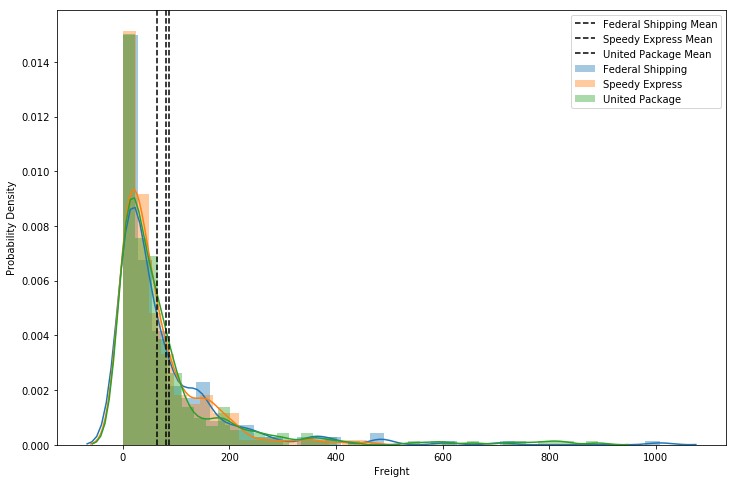

In [62]:
plt.figure(figsize=(12,8))
sns.distplot(Fed_df, label='Federal Shipping')
sns.distplot(Speed_df, label='Speedy Express')
sns.distplot(Unit_df, label='United Package')
plt.axvline(Fed_df.mean(), c='black', linestyle='--', label='Federal Shipping Mean')
plt.axvline(Speed_df.mean(), c='black', linestyle='--', label='Speedy Express Mean')
plt.axvline(Unit_df.mean(), c='black', linestyle='--', label='United Package Mean')
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# There is NOT a statistically significant difference between freight costs of the shippers


# Question 3: Is there a statistically significant difference in demand of produce each month?

Some of the code for this question was copied from https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb

First I will obtain the data. This one is a bit complicated. I will select the OrderDate column from Order, and the Quantity column from OrderDetail. I will join Order and OrderDetail by setting Order's Id column equal to OrderDetail's OrderId column. Then I will join that to Product by setting OrderDetail's ProductId column equal to Product's Id column. Then I will join that to Category by setting Product's CategoryId column equal to Category's Id column. Then I will use a "Where" clause to retrieve only the orders that deal with produce. Finally I will put the data into a pandas DataFrame.

In [63]:
# This cell of code taken from https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
query = """
SELECT o.OrderDate, od.Quantity FROM 
[Order] AS o JOIN OrderDetail AS od ON o.Id = od.OrderId
JOIN Product AS p ON od.ProductId = p.Id
JOIN Category as c ON p.CategoryId = c.Id
WHERE c.CategoryName = 'Produce'
"""

df3 = pd.DataFrame(c.execute(query).fetchall())
df3.columns = [x[0] for x in c.description]
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 2 columns):
OrderDate    136 non-null object
Quantity     136 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None


,OrderDate,Quantity
0,2012-07-05,9
1,2012-07-05,40
2,2012-07-08,35
3,2012-07-11,21
4,2012-07-22,15


Now I will group the data by month

In [64]:
# This cell of code taken from https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
df3.OrderDate = pd.to_datetime(df3.OrderDate)
df3['Month'] = df3.OrderDate.dt.month
df3.groupby('Month').mean()

,Quantity
Month,
1,16.545455
2,15.555556
3,21.500000
4,29.105263
5,12.888889
6,21.285714
7,26.375000
8,15.666667
9,17.500000


Now I will check each month to make sure it is normally distributed using a ks-test. If the p-value for the test is over 0.05 we can say the data is normally distributed.

In [65]:
for Month in df3.groupby('Month').Quantity:
    stat, p_value = stats.kstest(Month[1], "norm", args=(Month[1].mean(), Month[1].std()))
    if p_value < 0.05:
        print("One of the month's data is not normally distributed")

looks like everything is normal.

Now I will run a levene test on every month to see if they have equal variance. If the p-value of the test is over 0.05 we can say the pieces of data have equal variance.

In [66]:
Months = list(df3.groupby('Month').Quantity)
stats.levene(Months[0][1], Months[1][1], Months[2][1], Months[3][1], Months[4][1], Months[5][1], Months[6][1], Months[7][1], Months[8][1], Months[9][1], Months[10][1], Months[11][1])

LeveneResult(statistic=1.0145768797402832, pvalue=0.4375752511991626)

The variances are equal.

Now I will do an ANOVA test on the data. I will set the alpha level to 0.05, if the p-value is greater than that we can not reject the null hypothesis. I will formally state the assumptions for the ANOVA test as well as the hypotheses.<br>
<br>
Assumptions for the ANOVA test are as follows: <br>
* Equal Variances in the data
* Normally distributed data
* Randomally Selected Independent Samples

##### Null hypothesis: There is no statistically significant difference in quantity of produce ordered each month.
##### Alternative hypothesis There is a statistically significant difference in quantity of produce ordered each month.

In [67]:
# This cell of code taken from https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb
formula = "Quantity ~ C(Month)"
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4834.012843   11.0  1.318794  0.221691
Residual  41319.957745  124.0       NaN       NaN


Since the p-value is greater than the alpha level we have failed to reject the null hypothesis.

# There is NO statistically significant difference in demand of produce each month

# Question 4: Do products in the Meat/Poultry category have a higher unit price than products in the Seafood category?

First I will obtain the data. I need the UnitPrice column from the Product table and the CategoryName from the Category table. I will join the tables with Product's CategoryID column equal to Category's Id column. Finally I will put the data into a pandas DataFrame.

In [68]:
query = """
SELECT p.UnitPrice, c.CategoryName FROM Product as p JOIN Category as c ON p.CategoryID = c.Id
"""
df4 = pd.DataFrame(c.execute(query).fetchall())
df4.columns = [x[0] for x in c.description]
print(df4.info())
df4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
UnitPrice       77 non-null float64
CategoryName    77 non-null object
dtypes: float64(1), object(1)
memory usage: 1.3+ KB
None


,UnitPrice,CategoryName
0,18.00,Beverages
1,19.00,Beverages
2,10.00,Condiments
3,22.00,Condiments
4,21.35,Condiments


Now I will get the names of all the categories

In [69]:
df4.CategoryName.unique()

array(['Beverages', 'Condiments', 'Produce', 'Meat/Poultry', 'Seafood',
       'Dairy Products', 'Confections', 'Grains/Cereals'], dtype=object)

Now I will create two pandas series. One containing unit prices on meat/poultry and the other containing unit prices on seafood

In [70]:
Meat = df4[df4['CategoryName'] == 'Meat/Poultry'].UnitPrice
Seafood = df4[df4['CategoryName'] == 'Seafood'].UnitPrice
print(Meat.head(2))
print(Seafood.head(2))
print(Meat.mean())
print(Seafood.mean())

8     97.0
16    39.0
Name: UnitPrice, dtype: float64
9     31.0
12     6.0
Name: UnitPrice, dtype: float64
54.00666666666667
20.6825


Here we can see that the mean unit price for meat/poultry is higher than the mean unit price for seafood. Now Is time for the statistical test. I will first check length of the data and I will check the variances with a levene test to see if the variances are equal. If the resulting p-value is greater than 0.05 we can say that the variances are not significantly different from each other. Then I will test for normality using ks-tests If the p-value for the ks-tests is over 0.05 we can say the distribution is normal.

In [71]:
print(len(Meat), len(Seafood))

6 12


In [72]:
stats.levene(Meat, Seafood)

LeveneResult(statistic=4.356833516136663, pvalue=0.053214199374865705)

In [73]:
stats.kstest(Meat, "norm", args=(Meat.mean(), Meat.std()))

KstestResult(statistic=0.29524198262996504, pvalue=0.5863942867931975)

In [74]:
stats.kstest(Seafood, "norm", args=(Seafood.mean(), Seafood.std()))

KstestResult(statistic=0.21071511877100013, pvalue=0.6041337583016011)

Since the variances are not statistically different I will use a student's T-test. Let me now formally state the assumptions for the student's t-test and the hypotheses. <br>
<br>
Assumptions for the student's t-test: <br>
* Random Independent Samples
* Normality or sufficient sample size
* Equal variance
##### Null hypothesis: Products in the Meat/Poultry category have less than or equal unit price compared to products in the Seafood Category
##### Alternative hypothesis: Products in the Meat/Poultry category have a higher unit price than products in the Seafood Category<br>
Now its time for the test.

In [75]:
stats.ttest_ind(Meat, Seafood)

Ttest_indResult(statistic=2.337743630571393, pvalue=0.032718980448459896)

Since the p-value is below 0.05 we can reject the null hypthesis

# Products in the Meat/Poultry category have a statistically significant higher unit price than products in the Seafood category.

# Conclusion

We now know that:
* Discounts of any level have a statistically significant positive effect on quantity ordered.
* There is NOT a statistically significant difference between freight costs of the shippers.
* There is NO statistically significant difference in demand of produce each month.
* Products in the Meat/Poultry category have a statistically significant higher unit price than products in the Seafood category.

Business Recomendations:<br>
1) If the company needs to get rid of merchandise consider discounting the merchandise. <br>
2) Use whatever shipper is most convienient because they all cost the same. <br>
3) There is no need to stock up on different amounts of produce each month. <br>
4) Focus advertisement on meat and poultry rather than seafood <br>
